# Classify Credit Ratings

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import time
from sklearn.decomposition import PCA
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import BaggingClassifier

sns.set_style("whitegrid")

This code loads and displays the credit ratings data and a 7-fold cross-validated tree model of creditRatings.

In [2]:
creditRatings = pd.read_csv("./data/creditRatings.csv", dtype={'Rating': 'category'})
X, y = creditRatings.iloc[:, :-1], creditRatings.Rating
creditRatings.head()

,WC_TA,RE_TA,EBIT_TA,MVE_BVTD,S_TA,Rating
0,0.517,0.349,0.109,1.190,0.149,BBB
1,0.169,0.274,0.070,0.536,0.131,BB
2,0.536,0.863,0.107,4.549,0.583,AAA
3,0.313,0.511,0.078,3.461,0.452,AA
4,-0.029,0.081,0.028,0.971,0.226,BB


In [3]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.58333333 0.63888889 0.86111111 0.66666667 0.63888889 0.65714286
 0.62857143]
Mean accuracy: 0.6678004535147392
Cross validation elapsed time: 0.0340 seconds


Fit model with 2 predictors.
## Method: Feature Selection (Tree)

In [4]:
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X, y)

feature_importances = permutation_importance(classifier, X, y, n_repeats=10, random_state=0)
feature_importances = pd.DataFrame({'features': X.columns, 'importances_mean': feature_importances['importances_mean'], 
                                    'importances_std': feature_importances['importances_std']})
feature_importances.head()

,features,importances_mean,importances_std
0,WC_TA,0.1392,0.016762
1,RE_TA,0.2496,0.018608
2,EBIT_TA,0.0444,0.007473
3,MVE_BVTD,0.7344,0.018348
4,S_TA,0.1716,0.020587


<Figure size 640x480 with 0 Axes>

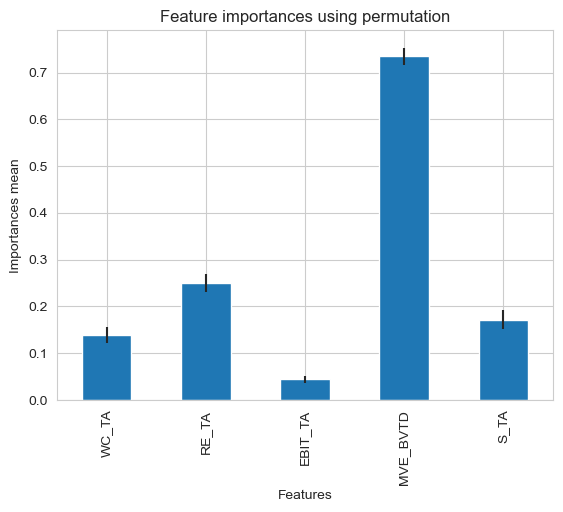

In [5]:
plt.figure()
feature_importances.plot.bar(x='features', y='importances_mean', yerr='importances_std', legend=None)
plt.title("Feature importances using permutation")
plt.xlabel("Features")
plt.ylabel("Importances mean")
plt.show()

In [6]:
fetures_keep = feature_importances['importances_mean'].sort_values(ascending=False)[:2].index
fetures_keep

X_selected = X[X.columns[fetures_keep]]
X_selected.head()

,MVE_BVTD,RE_TA
0,1.190,0.349
1,0.536,0.274
2,4.549,0.863
3,3.461,0.511
4,0.971,0.081


In [7]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_selected, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.66666667 0.80555556 0.52777778 0.61111111 0.55555556 0.68571429
 0.68571429]
Mean accuracy: 0.6482993197278912
Cross validation elapsed time: 0.0330 seconds


## Method: Feature Transformation (PCA)

In [8]:
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)
variance_ratio = pca.explained_variance_ratio_
pd.DataFrame(X_pca).head()

,0,1,2,3,4
0,-1.001338,-0.328730,0.264908,0.168674,-0.004782
1,-1.667535,-0.160815,0.092176,-0.064530,-0.012239
2,2.402732,-0.586306,-0.015491,0.113065,0.002122
3,1.282936,-0.244594,-0.013887,0.044811,-0.000780
4,-1.246717,0.121699,-0.042051,-0.101580,0.000999


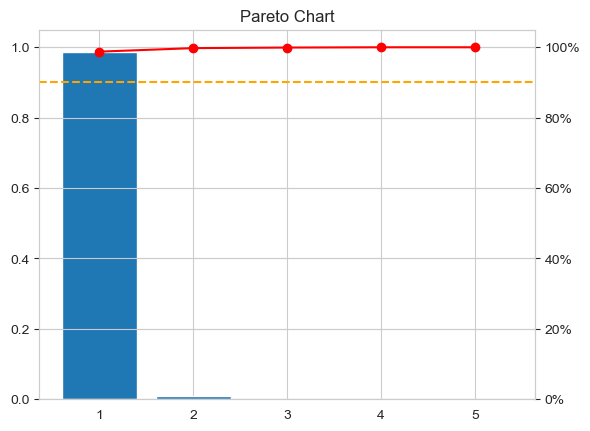

In [9]:
fig, ax = plt.subplots()

# Plot bars (i.e. frequencies)
ax.bar(np.arange(1, 6), variance_ratio)
ax.set_ylim(0, variance_ratio.sum()*1.05)
ax.set_title("Pareto Chart")
ax.set_xticks(np.arange(1, 6))

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(np.arange(1, 6), (variance_ratio * 100).cumsum(), color="red", marker="o")
ax2.axhline(90, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim(0, 100*1.05)

plt.show()

In [10]:
X_pca = X_pca[:, :2]
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_pca, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.63888889 0.66666667 0.66666667 0.66666667 0.63888889 0.62857143
 0.57142857]
Mean accuracy: 0.6396825396825395
Cross validation elapsed time: 0.0170 seconds


Fit ensemble with 3 or fewer predictors.

## Method: Feature Selection (Tree)

In [11]:
classifier = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_selected, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.72222222 0.75       0.75       0.61111111 0.75       0.62857143
 0.74285714]
Mean accuracy: 0.7078231292517007
Cross validation elapsed time: 0.1480 seconds


## Method: Feature Transformation (PCA)

In [12]:
classifier = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
kf = KFold(n_splits=7, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_pca, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.63888889 0.69444444 0.69444444 0.66666667 0.66666667 0.6
 0.74285714]
Mean accuracy: 0.6719954648526077
Cross validation elapsed time: 0.1335 seconds
